In [43]:
import os
import uuid

os.environ['HF_HOME'] = 'hf_cache'

import matplotlib.pyplot as plt

from model.modeling_llama import LlamaForCausalLM as ModifiedLlama
from transformers import AutoTokenizer, AutoModelForCausalLM
from kvcache.iterative import IterativeReduceKVBiasCache as ModifiedCache
from transformers import DynamicCache
from datasets import load_dataset

import torch
import numpy as np
import random

import torch.nn.functional as F
import time
from IPython.display import DisplayHandle

import os
import random
import pandas as pd

import seaborn as sns

DEVICE = 'cuda'
DTYPE = torch.float32
FIRST_N = 10

BATCH_SIZE = 1
SAMPLE_SIZE = 1
MAX_LENGTH = 1000
N_SEEDED = 1

PROTECT_FIRST = 20
ROLLING_WINDOW = 50

In [44]:
torch.cuda.is_available()

True

In [45]:
# Define the cache file name
CACHE_FILENAME = f"fineweb_sample{SAMPLE_SIZE}of{FIRST_N}.csv"

# Check if the cache file already exists
if os.path.exists(CACHE_FILENAME):
    print(f"Cache file already exists: {CACHE_FILENAME}")
    df = pd.read_csv(CACHE_FILENAME)
else:
    # Load streaming dataset
    dataset = load_dataset("HuggingFaceFW/fineweb-edu", split="train", name="sample-10BT", streaming=True)
    stream = iter(dataset)

    samples = [next(stream) for _ in range(FIRST_N)]
    selected_samples = random.sample(samples, SAMPLE_SIZE)

    # Convert to DataFrame
    df = pd.DataFrame(selected_samples)

    # Save to CSV
    df.to_csv(CACHE_FILENAME, index=False, encoding="utf-8")
    print(f"Saved CSV with {len(df)} samples to: {CACHE_FILENAME}")

texts = df["text"]

Resolving data files:   0%|          | 0/2110 [00:00<?, ?it/s]

Saved CSV with 1 samples to: fineweb_sample1of10.csv


In [66]:
def get_cache_size(cache: DynamicCache | ModifiedCache, max_len: int):
    n_layers = len(cache.key_cache)
    n_heads = len(cache.key_cache[0][0])
    n_exmpl = len(cache.key_cache[0])
    
    if not isinstance(cache, ModifiedCache):
        for i in range(n_exmpl):
            yield {'Cache Size (% of max)': 100}
    else:
        layer_sum = 0
        n_layers = 0
        for layer, last_available_per_head in enumerate(cache.last_available_idx):
            ratio = torch.max(last_available_per_head, dim=-1)[0] / max_len
            layer_sum += ratio * 100
            n_layers += 1
        
        mean = layer_sum / n_layers
        for i in range(n_exmpl):
            yield {'Cache Size (% of max)': mean[i].item()}


def eval_match_ignored_order(pred: set[int], gold: set[int]) -> float:
    same = gold.intersection(pred)
    return 100 * len(same) / len(gold)
                

def stepwise_perplexity(
        model, tokenizer, texts, cache_impl, 
        gold: list[set[int]] = None, 
        update_every=1, 
        max_length=MAX_LENGTH,
        seed_run: bool = False,
        step_size: int = 1,
):
    MS = step_size
    loss_fn = torch.nn.CrossEntropyLoss(reduction='none')

    total_texts = len(texts)

    display_handle = DisplayHandle()
    display_handle.display("Starting perplexity evaluation...")
    
    # track: PPL, Text Idx, Step, Cache Class
    results = []
    
    # track: Cache Size (% of max), Layer ID, Head ID, Text Idx, Step
    results_cache = []

    gold_iter = iter(gold) if gold is not None else None
    
    seed_tokens = torch.tensor([], dtype=torch.long)
    if seed_run:
        seed = '<text_uid>' + str(uuid.uuid4()) + '</text_uid>\n\n'
        seed_tokens = tokenizer([seed], return_tensors="pt", truncation=True, max_length=max_length)["input_ids"]
        
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    total_batches = (len(texts) // BATCH_SIZE) + bool(len(texts) % BATCH_SIZE)
    for batch_idx in range(total_batches):
        batch_texts = list(texts[batch_idx * BATCH_SIZE:(batch_idx + 1) * BATCH_SIZE])
        enc = tokenizer(batch_texts, return_tensors="pt", truncation=True, max_length=max_length, padding=True)
        new_input_ids = enc["input_ids"]
        B = new_input_ids.size(0)
        input_ids = torch.concat([seed_tokens.expand(B, -1), enc["input_ids"]], dim=-1).to(DEVICE)
        cache = cache_impl()
        
        extra_info = {}
        cache_class_extended = None
        if isinstance(cache, ModifiedCache):
            cache_class_extended = cache.__class__.__name__ + f"(MVI={cache.mvi:.1f})"
            cache_class = cache.__class__.__name__
            extra_info = {
                'MVI': cache.mvi,
                'OF': step_size
            }
        else:
            cache_class = "Normal"
            extra_info = {
                'MVI': 'N/A',
                'OF': 'N/A'
            }
        
        if seed_run:
            cache_class += " Seeded"
        
        if cache_class_extended is None:
            cache_class_extended = cache_class
        
        S = input_ids.size(1)
        
        total_loss = 0.0
        total_tokens = 0
        
        skip_count = 0
        if seed_run:
            skip_count = seed_tokens.size(1)

        # Autoregressive token-by-token loop
        for i in range(1, (S // MS) + 2):
            start = (i - 1) * MS
            end = min(i * MS, S - 1)
            if end <= start:
                continue
            
            input_slice  = input_ids[:, start : end]          # [B, MS]
            label_tokens = input_ids[:, start + 1: end + 1] # [B, MS]
            
            curr_MS = end - start
            if not curr_MS:
                continue

            with torch.no_grad():
                output = model(
                    input_ids=input_slice,
                    use_cache=True,
                    past_key_values=cache,
                    cache_position=torch.arange(start, end, device=DEVICE, dtype=torch.long),
                )
                cache = output.past_key_values
                logits = output.logits # [B, MS, vocab_size]
                
            if skip_count <= 0:
                loss = loss_fn(logits.reshape(-1, logits.size(-1)), label_tokens.reshape(-1))
                total_loss += loss.sum().cpu().numpy()
                total_tokens += B * curr_MS
                
                top_5 = logits.topk(k=5, dim=-1)[1]
                
                # Update the display every update_every steps
                if total_tokens % update_every == 0 or (i == S - 1 and batch_idx == total_batches - 1):
                    current_ppl = np.exp(total_loss / total_tokens)
                    status = (f"Batch {batch_idx + 1}/{total_batches} | "
                              f"Step {i + 1}/{S // MS} | "
                              f"Cumulative PPL: {float(current_ppl.mean()):.2f}")
                    display_handle.update(status)
            
                for local_text_idx in range(B):
                    text_idx = batch_idx * BATCH_SIZE + local_text_idx
                    
                    for local_token_idx in range(curr_MS):
                        assert tokenizer.pad_token_id is not None
                        if label_tokens[local_text_idx, local_token_idx].item() == tokenizer.pad_token_id:
                            continue
                        local_top_5 = top_5[local_text_idx, local_token_idx].tolist()
                        token_idx = (i - 1) * MS + local_token_idx
                    
                        # Append current results:
                        # For each token, we collect the current perplexity estimate, the cache class, 
                        # the text index, and the current step number.
                        step_idx = token_idx - (seed_tokens.size(1) if seed_run else 0)
                        results.append({
                            "Top 5 Tokens": local_top_5,
                            "MatchUnordered@5": eval_match_ignored_order(
                                set(local_top_5), 
                                gold[text_idx][step_idx]
                            ) if gold is not None else 100.0,
                            "Cache Class": cache_class,
                            "Cache Class (Ext.)": cache_class_extended,
                            "Text Idx": text_idx,
                            "Step": step_idx,
                            **extra_info
                        })
                    
                    results_cache.extend([
                            {
                            "Text Idx": text_idx,
                            "Step": (i - 1) * MS + curr_MS - (seed_tokens.size(1) if seed_run else 0),
                            "Cache Class": cache_class,
                            **d,
                            **extra_info
                        }
                        for d in get_cache_size(cache, max_len=end)  
                    ])
                
            skip_count -= 1

    return results, results_cache

def get_gold(res: list[dict]) -> list[list[set]]:
    result = []
    data = pd.DataFrame(res).groupby(["Text Idx", "Step"])
    for i, datapoint in data:
        text_idx = int(datapoint["Text Idx"].iloc[0])
        step = int(datapoint["Step"].iloc[0])
        while len(result) <= text_idx:
            result.append([])
        target = result[text_idx]
        while len(target) <= step:
            target.append(None)
        target[step] = set(datapoint["Top 5 Tokens"].iloc[0])
    return result

In [60]:
def plot(data, target="PPL", ylim=None, rolling_window=None, hue='MVI'):
    """
    Plots the specified target over steps from the given data. Optionally 
    applies a window-based rolling mean to smooth the plot.

    :param data: List of dictionaries or a Pandas DataFrame that must include
                 columns 'Step', 'Cache Class', and <target>.
    :param target: The target column to plot (e.g. "PPL").
    :param ylim: A tuple (min, max) that specifies the y-axis range.
    :param smoothing_window: Size of the rolling window for smoothing. If set 
                            to None, no smoothing is applied.
    """
    df = pd.DataFrame(data)

    # Optionally apply smoothing
    if rolling_window is not None and rolling_window > 1:
        df[target] = df.groupby(["Cache Class", "Text Idx"])[target] \
                       .transform(lambda s: s.rolling(rolling_window, min_periods=1).mean())

    plt.figure(figsize=(12, 7))
    sns.lineplot(x="Step", y=target, style="Cache Class", hue=hue, data=df)
    if ylim:
        plt.ylim(ylim)
    plt.title(f"{target} vs. Step" + (f" (Rolling Window = {rolling_window})" if rolling_window else ""))
    plt.show()
    
    
def plot_cache(data, hue='MVI', ylim=(20, 100)):
    plt.figure(figsize=(12, 7))
    plt.ylim(ylim)
    sns.lineplot(y="Cache Size (% of max)", x="Step", data=pd.DataFrame(data), style="Cache Class", hue=hue)

In [61]:
#texts = [texts[0]]

In [62]:
model_hf = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM2-135M")
model_hf.eval().to(DEVICE).to(DTYPE)

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-135M")

In [63]:
results, results_cache = stepwise_perplexity(model_hf, tokenizer, texts, cache_impl=lambda: None, step_size=10)
gold = get_gold(results)
len(gold[0]), len(gold)

'Batch 1/1 | Step 98/96 | Cumulative PPL: 20.44'

(968, 1)

In [64]:
model_mod = ModifiedLlama.from_pretrained("HuggingFaceTB/SmolLM2-135M", attn_implementation="eager")
model_mod.eval().to(DEVICE).to(DTYPE)

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-135M")

'Batch 1/1 | Step 969/969 | Cumulative PPL: 36.96'

'Batch 1/1 | Step 485/484 | Cumulative PPL: 13.54'

'Batch 1/1 | Step 243/242 | Cumulative PPL: 8.20'

'Batch 1/1 | Step 122/121 | Cumulative PPL: 13.51'

'Batch 1/1 | Step 62/60 | Cumulative PPL: 10.47'

'Batch 1/1 | Step 32/30 | Cumulative PPL: 22.37'

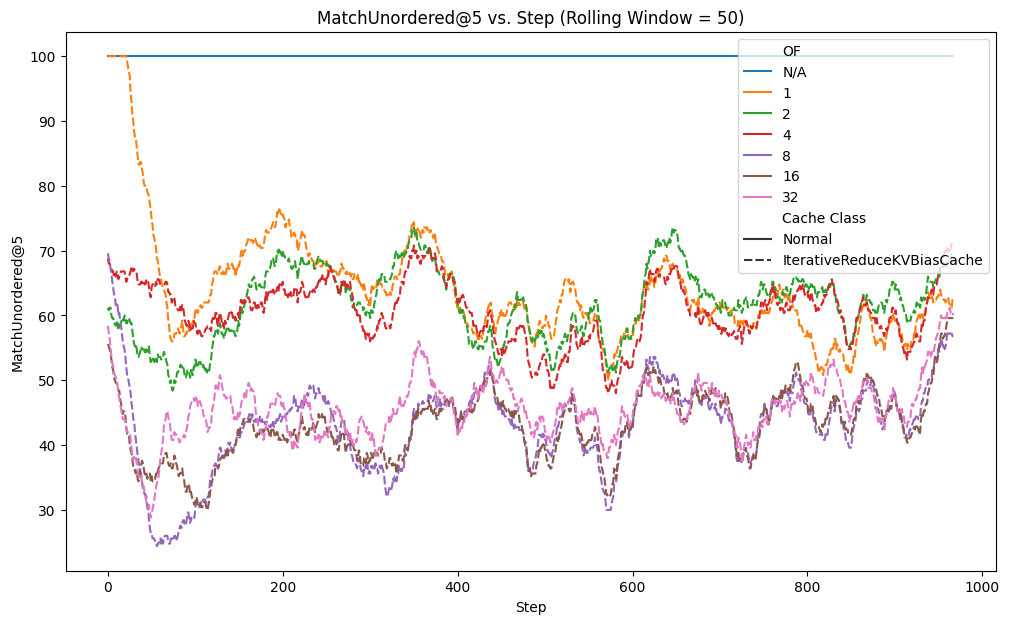

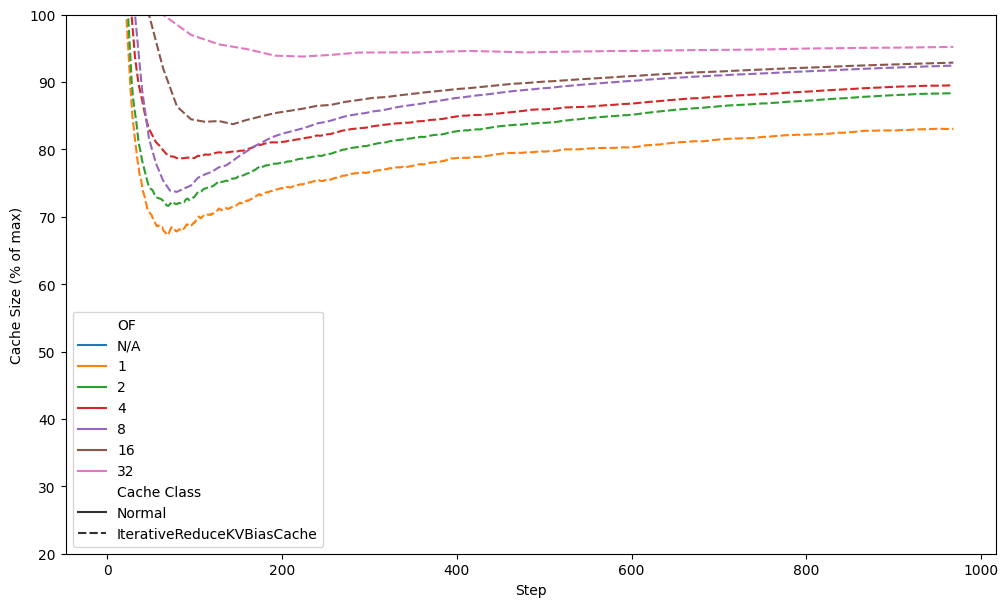

In [67]:
import copy
results_sf, results_cache_sf = copy.deepcopy(results), copy.deepcopy(results_cache)
for step_freq in [1, 2, 4, 8, 16, 32]:
    res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(mvi=100.0), step_size=step_freq)
    results_sf += res
    results_cache_sf += resc

plot(results_sf, target="MatchUnordered@5", rolling_window=ROLLING_WINDOW, hue='OF')
plot_cache(results_cache_sf, hue='OF')

'Batch 1/1 | Step 51/50 | Cumulative PPL: 27.99'

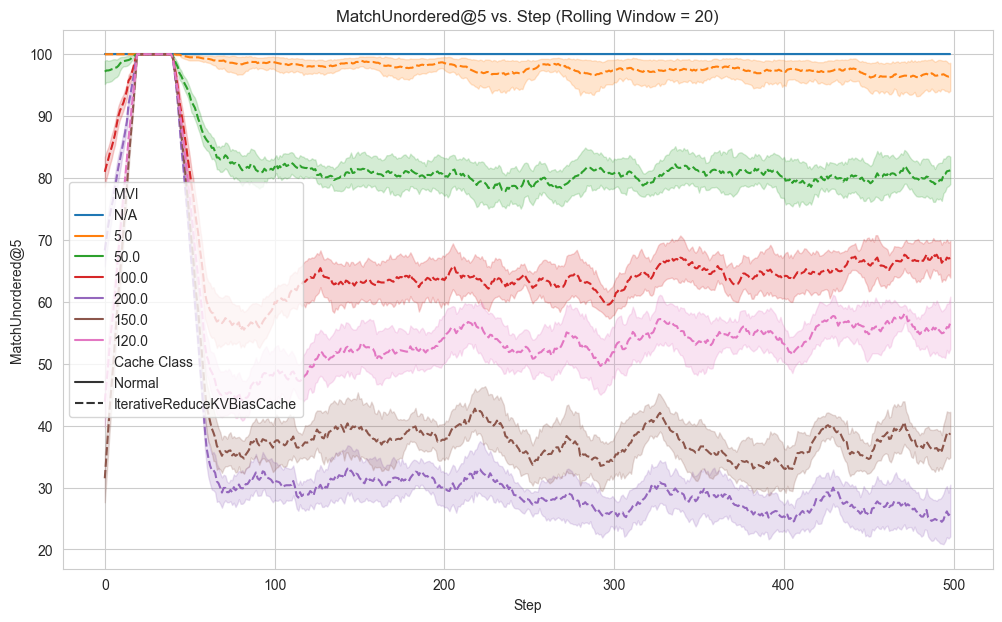

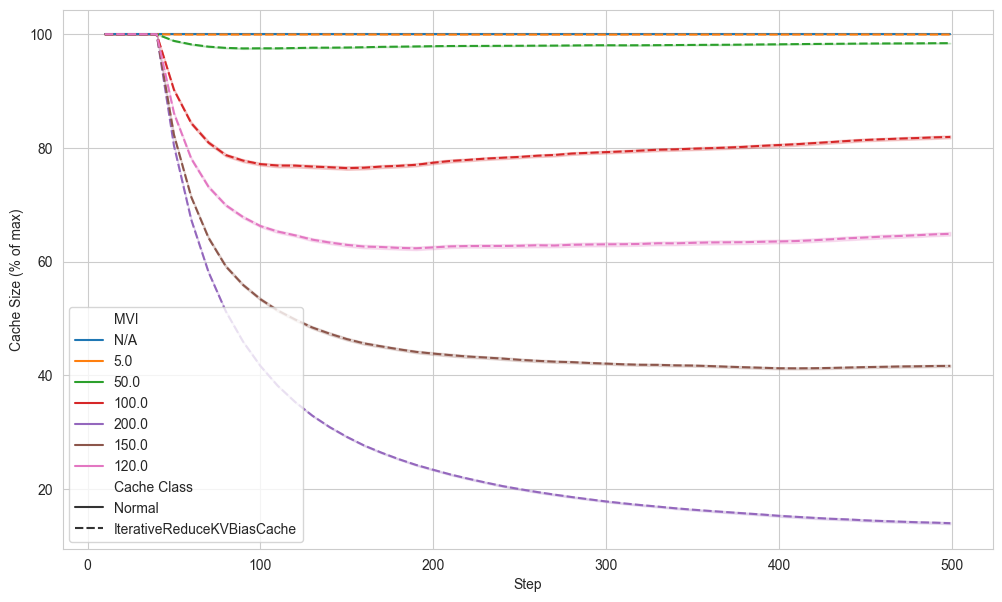

In [16]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(mvi=120.0), step_size=10)
results += res
results_cache += resc
plot(results, target="MatchUnordered@5", rolling_window=20)
plot_cache(results_cache)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_mvi=5.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5", rolling_window=ROLLING_WINDOW)
plot_cache(results_cache)

In [ ]:
# compute normal variations of the metric
for _ in range(N_SEEDED):
    res, resc = stepwise_perplexity(model_hf, tokenizer, texts, gold=gold, cache_impl=lambda: None, seed_run=True)
    results += res
    results_cache += resc
    
plot(results, target="MatchUnordered@5", rolling_window=ROLLING_WINDOW)
plot_cache(results_cache)

'Batch 1/1 | Step 100/100 | Cumulative PPL: 25.82'

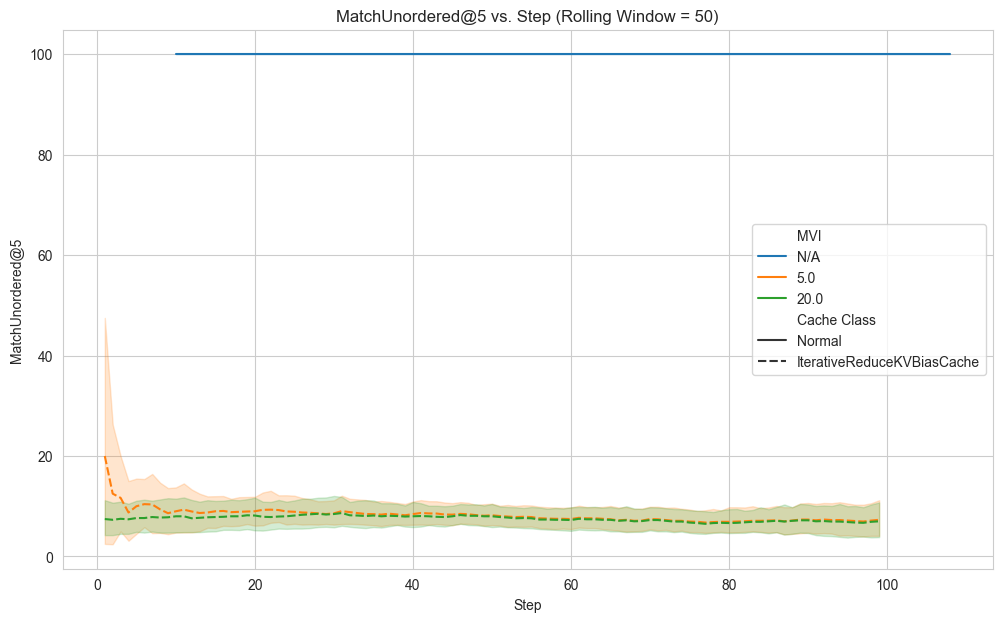

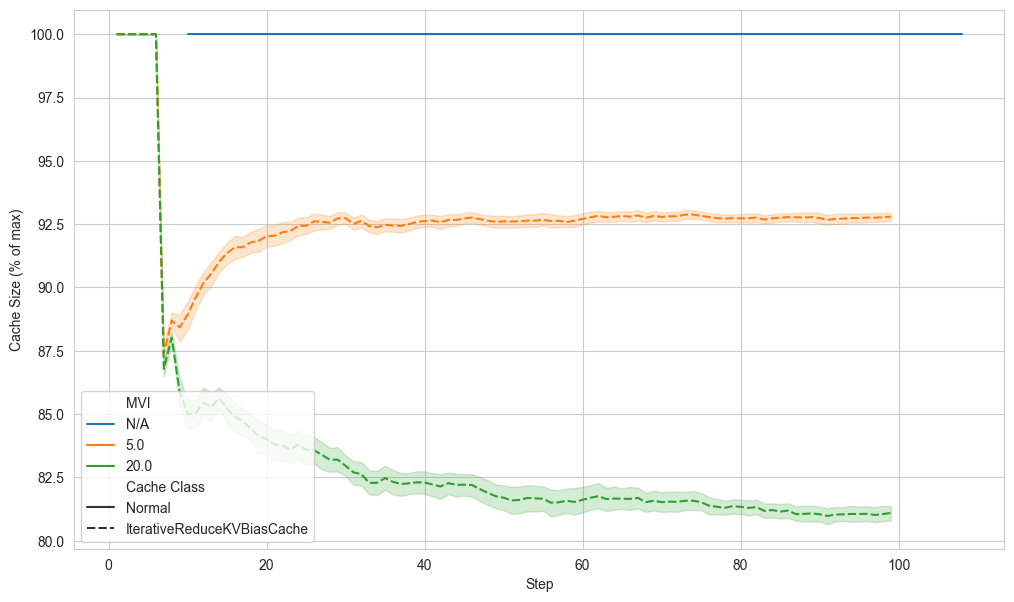

In [12]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_mvi=20.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5", rolling_window=ROLLING_WINDOW)
plot_cache(results_cache)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_mvi=40.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5", rolling_window=ROLLING_WINDOW)
plot_cache(results_cache)

'Batch 1/1 | Step 11/10 | Cumulative PPL: 21.80'

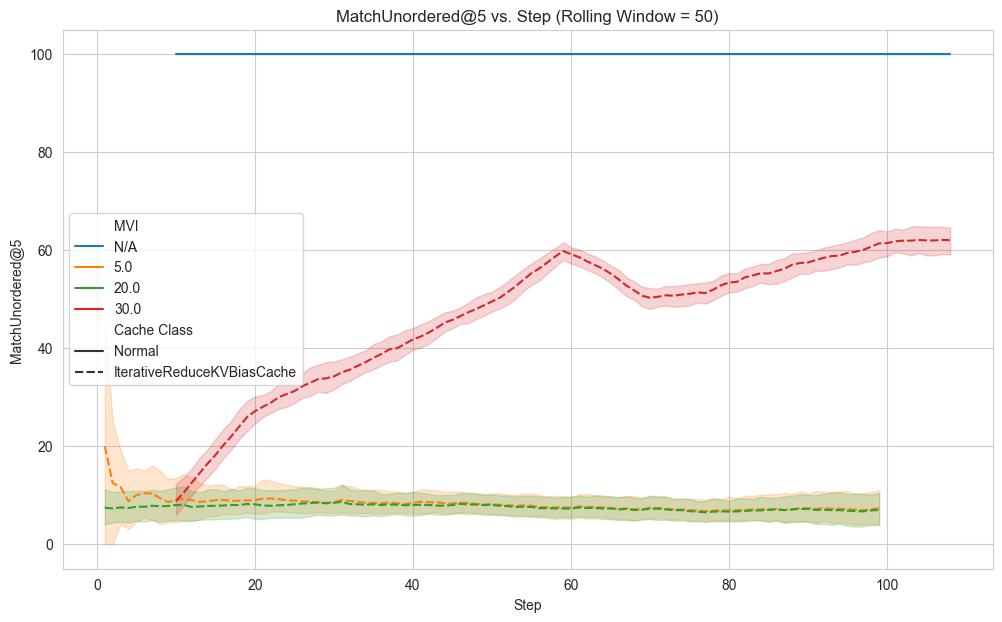

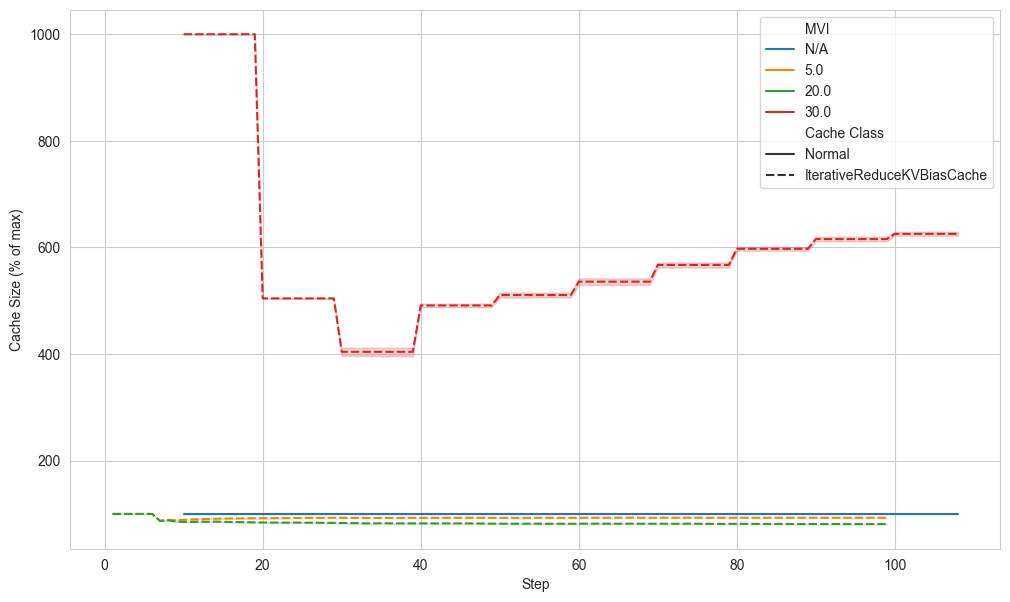

In [13]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_mvi=30.0), step_size=10)
results += res
results_cache += resc
plot(results, target="MatchUnordered@5", rolling_window=ROLLING_WINDOW)
plot_cache(results_cache)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_mvi=50.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5", rolling_window=ROLLING_WINDOW)
plot_cache(results_cache)

In [11]:
MODEL = 'meta-llama/Meta-Llama-3-8B'
model_hf = AutoModelForCausalLM.from_pretrained(MODEL)
model_hf.eval().to(DEVICE).to(DTYPE)

tokenizer = AutoTokenizer.from_pretrained(MODEL)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [12]:
results, results_cache = stepwise_perplexity(model_hf, tokenizer, texts, cache_impl=lambda: None)
gold = get_gold(results)

'Batch 1/1 | Step 500/500 | Cumulative PPL: 275.46'

In [80]:
model_mod = ModifiedLlama.from_pretrained(MODEL, attn_implementation="eager")
model_mod.eval().to(DEVICE).to(DTYPE)

tokenizer = AutoTokenizer.from_pretrained(MODEL)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

'Batch 1/1 | Step 500/500 | Cumulative PPL: 275.46'

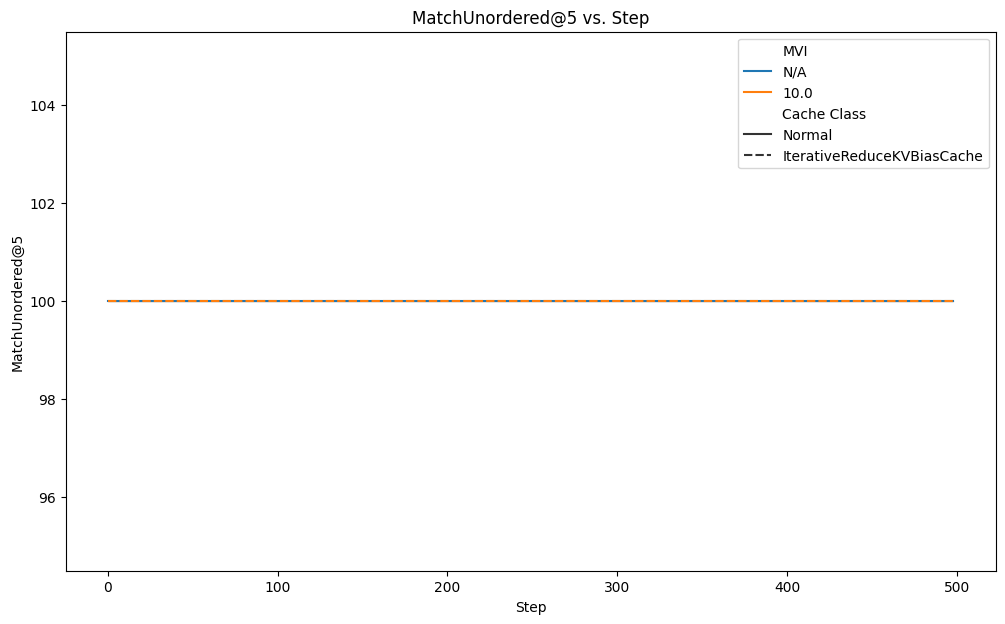

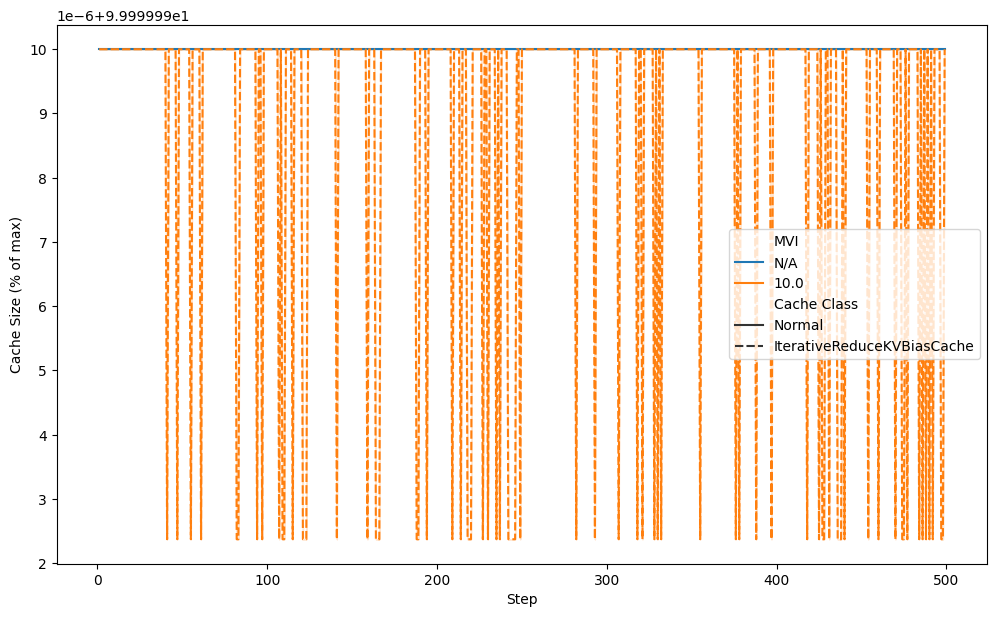

In [15]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(mvi=10.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5")
plot_cache(results_cache)

'Batch 1/1 | Step 500/500 | Cumulative PPL: 274.20'

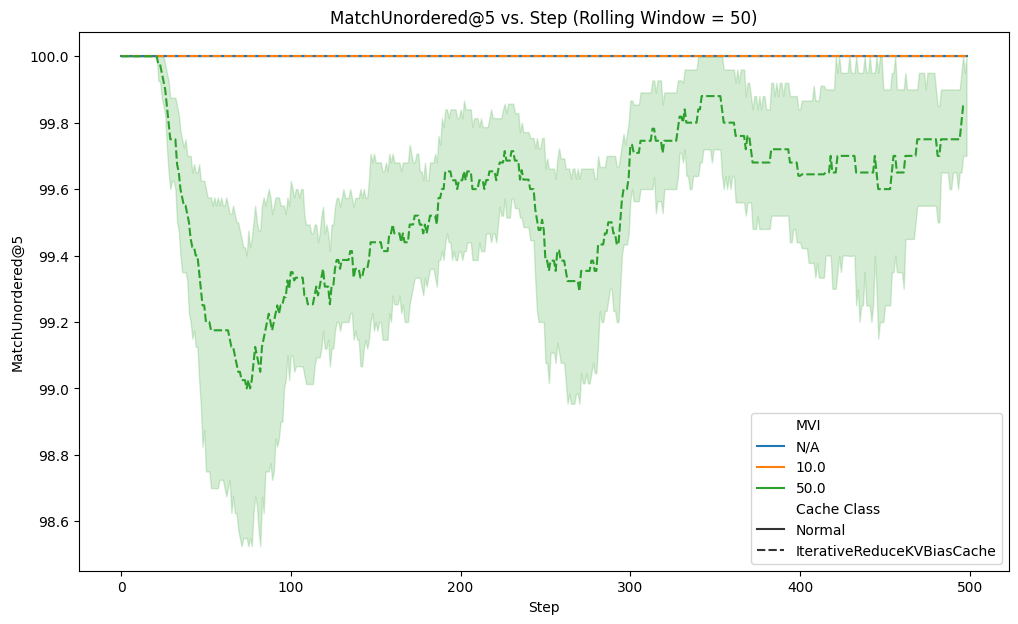

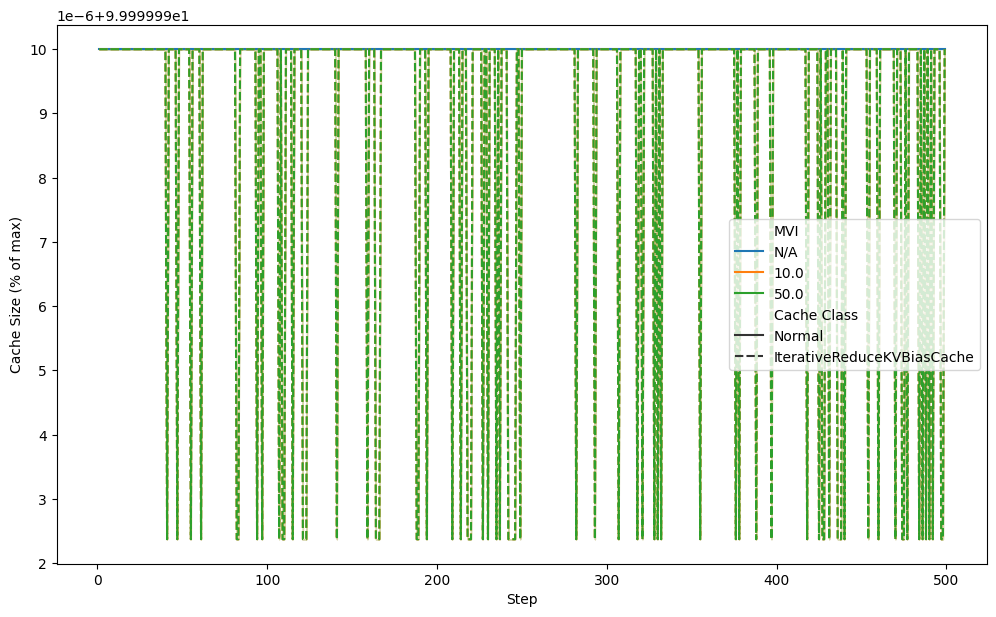

In [17]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(mvi=50.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5", rolling_window=ROLLING_WINDOW)
plot_cache(results_cache)

'Batch 1/1 | Step 500/500 | Cumulative PPL: 269.37'

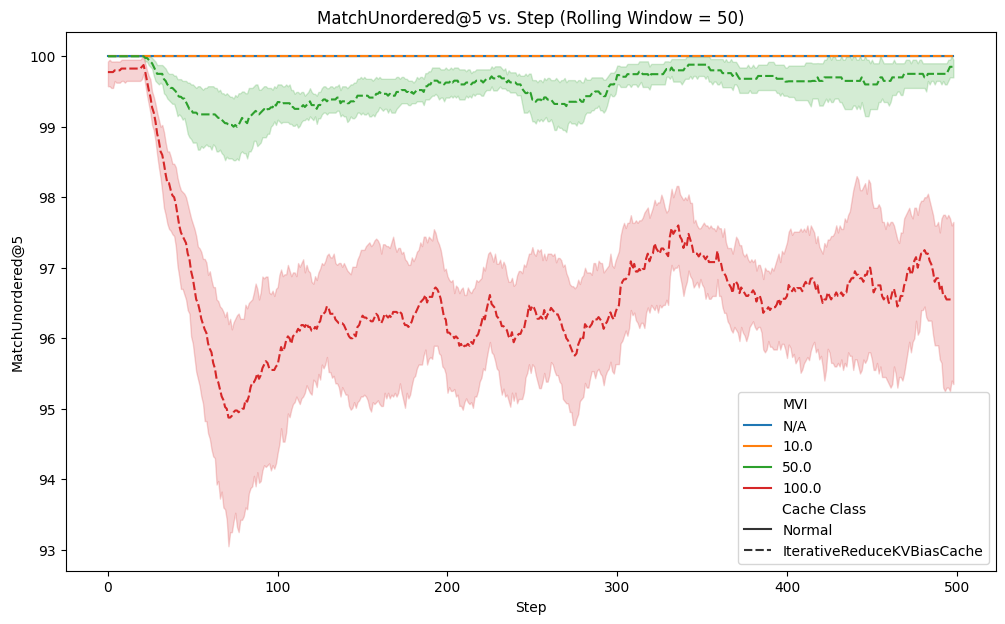

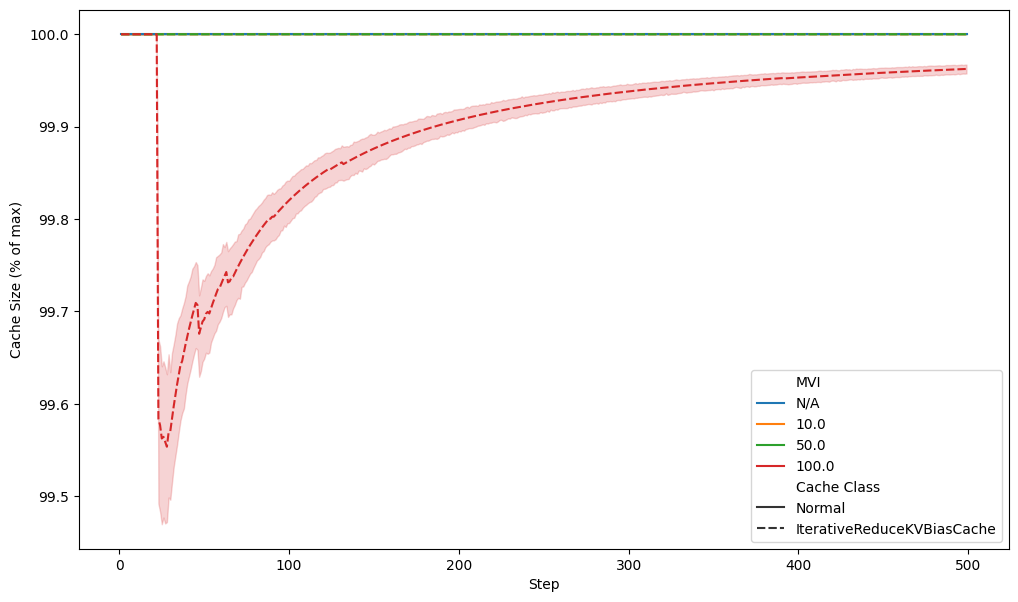

In [18]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(mvi=100.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5", rolling_window=ROLLING_WINDOW)
plot_cache(results_cache)

'Batch 1/1 | Step 500/500 | Cumulative PPL: 233.75'

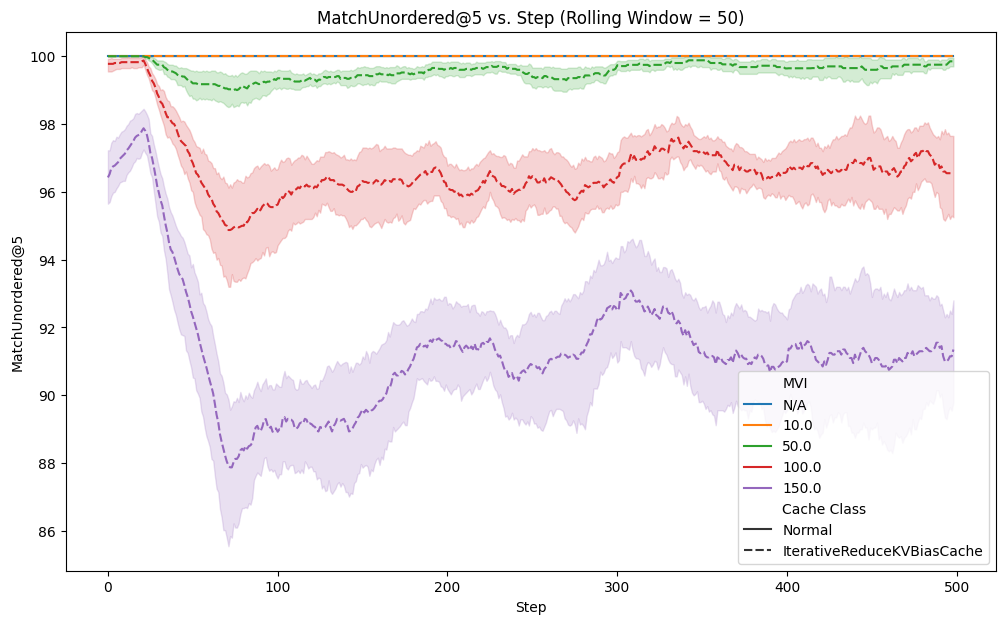

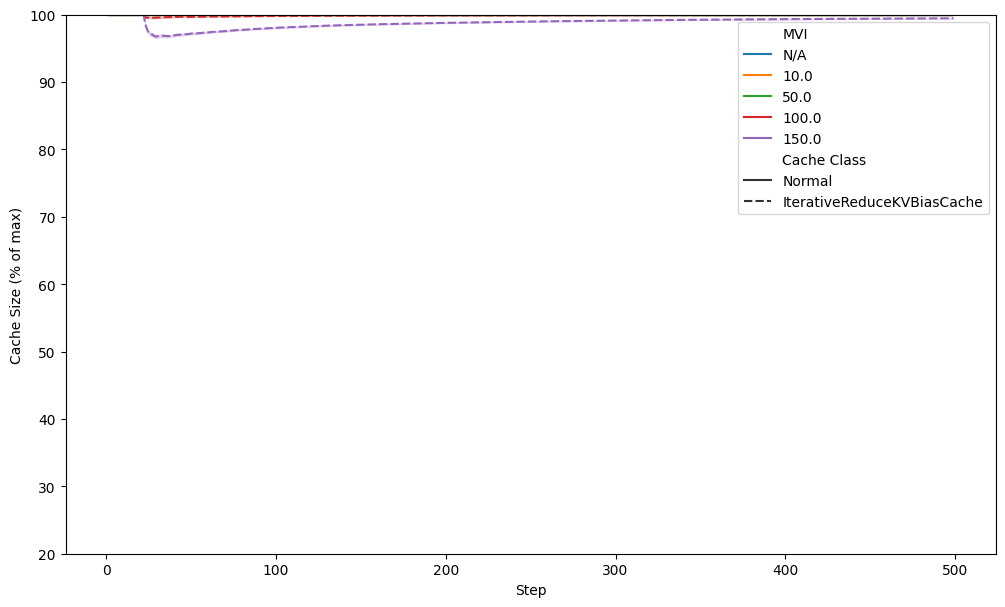

In [20]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(mvi=150.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5", rolling_window=ROLLING_WINDOW)
plot_cache(results_cache)

'Batch 1/1 | Step 500/500 | Cumulative PPL: 1574.35'

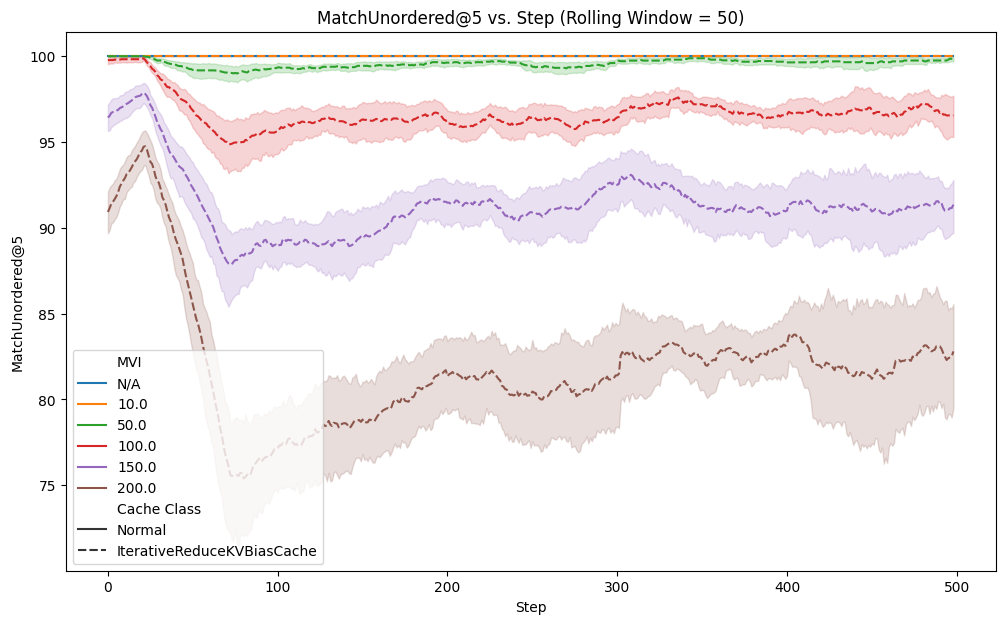

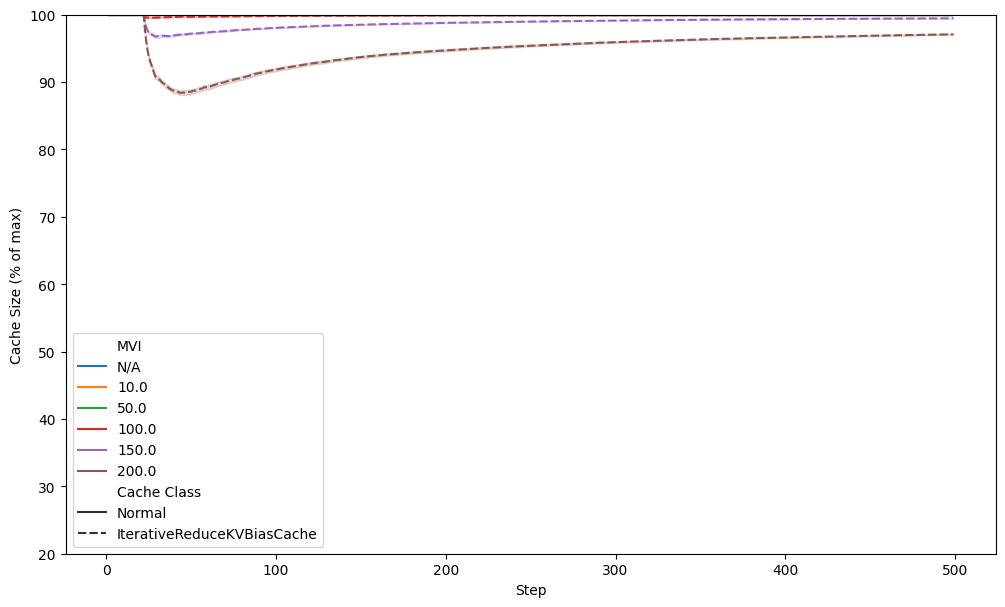

In [21]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(mvi=200.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5", rolling_window=ROLLING_WINDOW)
plot_cache(results_cache)

'Batch 1/1 | Step 500/500 | Cumulative PPL: 984.96'

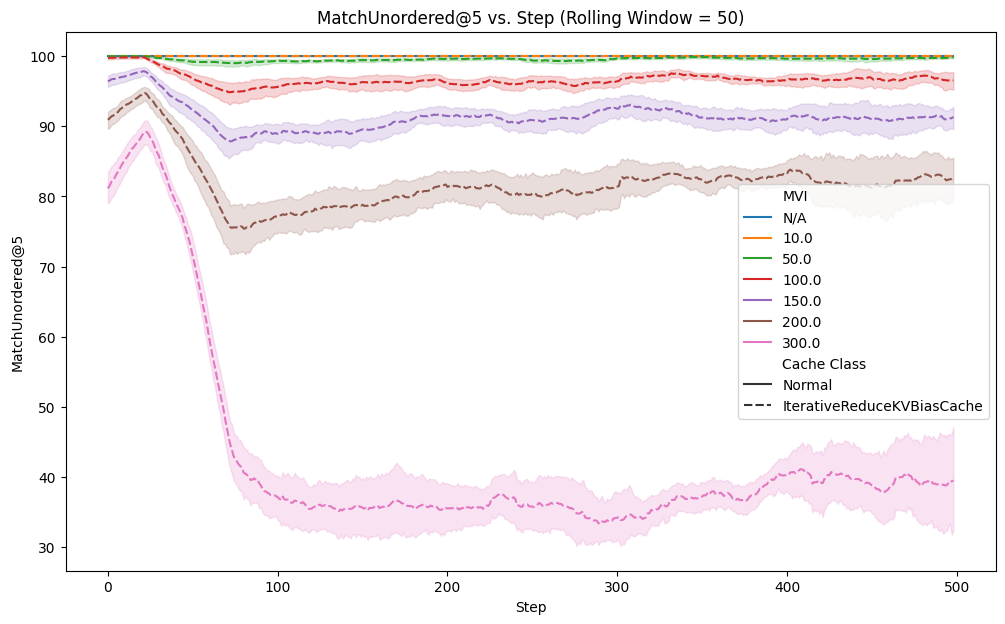

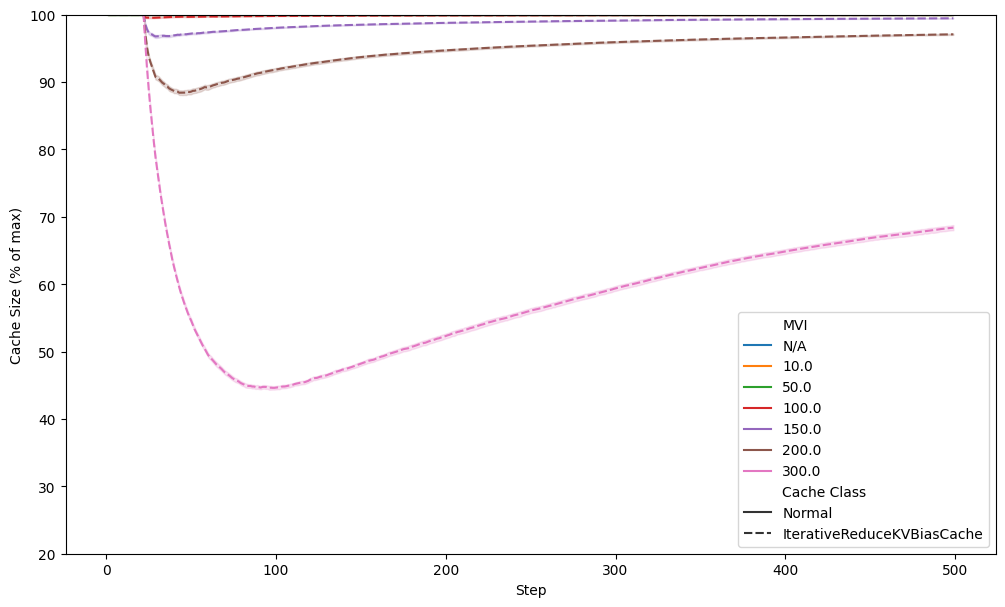

In [22]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(mvi=300.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5", rolling_window=ROLLING_WINDOW)
plot_cache(results_cache)

In [ ]:
res, resc = stepwise_perplexity(model_mod, tokenizer, texts, gold=gold, cache_impl=lambda: ModifiedCache(max_mvi=150.0))
results += res
results_cache += resc
plot(results, target="MatchUnordered@5")
plot_cache(results_cache)

In [ ]:
print(texts[0])

In [71]:
def stepwise_generate(model, tokenizer, prompt, cache_impl, update_every=10, n_generate=100, top_n=10):
    display_handle = DisplayHandle()
    display_handle.display("Starting generation...")

    enc = tokenizer(prompt, return_tensors="pt")
    input_ids = enc["input_ids"].squeeze(0).to(model.device)
    cache = cache_impl()
    
    seq_len = input_ids.size(0)

    # Autoregressive token-by-token loop
    for i in range(1, seq_len + n_generate):
        input_slice = input_ids[i - 1 : i].unsqueeze(0)  # [1, 1]

        with torch.no_grad():
            output = model(
                input_ids=input_slice,
                use_cache=True,
                past_key_values=cache,
                cache_position=torch.tensor([i - 1], device=model.device, dtype=torch.long),
            )
            cache = output.past_key_values
            logits = output.logits[0, -1, :]  # [vocab_size]

            # Get the top 'top_n' tokens and their corresponding probabilities
            top_n_logits, top_n_indices = torch.topk(logits, top_n)
            top_n_probs = torch.softmax(top_n_logits, dim=-1)
            predicted_token = top_n_indices[torch.multinomial(top_n_probs, num_samples=1)]

            if i >= seq_len:
                input_ids = torch.cat((input_ids, predicted_token), dim=-1)

        # Update the display every update_every steps
        if i % update_every == 0 or i == seq_len + n_generate - 1:
            status = tokenizer.decode(input_ids)
            display_handle.update(status)
    
    if isinstance(cache, ModifiedCache):
        print(100 * (torch.stack(cache.last_available_idx) / (seq_len + n_generate)).mean().item(), '%')

In [81]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(mvi=1.0))

'<|begin_of_text|>Once upon a time, 2000 BC, a great civilisation ruled over all of the known world. They were known as the Sumerians and were the first to create a written language and a sophisticated form of mathematics. In their language there were 600 symbols for numbers and their numbers were written out in full. It wasn’t until 3000 years later that the Greeks invented the concept of zero and developed what we know as our modern number system.\nThe Sumerians were very clever in their use of mathematics and'

99.06541705131531 %


In [82]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(mvi=5.0))

'<|begin_of_text|>Once upon a time, 2nd generation Chinese Americans would have been the first in their families to go to university. Today, a Chinese family’s expectations for their child’s education have changed. A Chinese American child’s college education may not seem so out of the ordinary these days; in fact, it has become a cultural norm. As a result, Chinese American parents have begun to set their sights on their children’s higher education. For many parents, the expectation is to send their children to the most prestigious schools in the US'

99.05811548233032 %


In [83]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(mvi=10.0))

'<|begin_of_text|>Once upon a time, 2,800 years ago, a king called Solomon ruled over Israel. His name means peaceful and his father’s name means love. Solomon was a man of peace and love. He was not only a great leader, but also a great builder and a great poet. He was the wisest king that ever lived, and it is he who wrote the book of Proverbs.\nSolomon was known far and wide for his wisdom. His name was known even to the queen of Sheba who had heard'

99.05446767807007 %


In [84]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(mvi=20.0))

'<|begin_of_text|>Once upon a time, 3D printing was a futuristic, out of reach technology. Now, it’s everywhere, and is changing the way companies manufacture products. From prototyping to manufacturing to end-use parts, 3D printing can help companies create better products, faster. The technology isn’t perfect, though. There are still some barriers that prevent companies from using it as they please. Here are a few 3D printing issues to be aware of.\nThe Cost Of Materials\n3D Printers are still relatively expensive'

98.99605512619019 %


In [85]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(mvi=50.0))

'<|begin_of_text|>Once upon a time, 10 years ago (and for some of my younger readers, not long ago), the Internet didn’t exist in the way we know today. There was no Facebook, no Twitter, not even YouTube, and if you wanted to get on the net, you probably had to use a dial-up connection on a desktop computer.\nIn 2000, I was working at AOL in the marketing group, helping the company promote its services. One of my projects was to create AOL Instant Messenger (AIM) av'

98.66384267807007 %


In [86]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(mvi=100.0))

"<|begin_of_text|>Once upon a time, 25-year old, single, childless woman, who is not in the process of becoming pregnant, and who doesn't want children, was asked why she doesn't have children. She was told she was a selfish woman, a bad person. She has been called a child murderer. She has been told by the Church and by society that she will burn in a hot and fiery furnace forever because she doesn't want children. This is not fair. She was born a woman with the same basic rights"

94.32680606842041 %


In [87]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(mvi=70.0))

'<|begin_of_text|>Once upon a time, 30 years ago, I was a young and very impressionable art student, and was introduced to one of my favourite artists of all time – the late and truly great Keith Haring.\xa0 I can remember exactly where I was and what I was doing when a good friend of mine, who was also a fellow student, introduced me to his art work.\nAt the time, there was a lot of graffiti art going on in Melbourne, and my friend was part of a team called The Dots,'

97.64894247055054 %


In [88]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(mvi=70.0))

'<|begin_of_text|>Once upon a time, 30 years ago, I met someone. And we fell in love. And we were married.\nAnd we had a family together, a family of two. We did everything together. We worked together, we had fun together, and we made love together.\nWe went on vacation together, we moved houses together, we moved cities together, we had friends together, and we had our ups and downs, just like any couple in their late twenties. And then something happened.\nHe had an affair. And'

96.33104801177979 %


In [90]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(mvi=100.0))

'<|begin_of_text|>Once upon a time, 25 years ago, there was a little company in a tiny village in South Yorkshire that was producing one of the best sounding speakers in the world and, as a result, became one of the most successful hi-fi speaker manufacturer ever. The company that started as a dream and grew into a reality and, as a tribute to the man who started it all, the company changed its name from Bowers and Wilkins to Bowers and Wilkins, or simply Bowers Wilkins and the dream continued.'

93.92157793045044 %


In [91]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(mvi=150.0))

'<|begin_of_text|>Once upon a time, 3D printing was just a niche activity that appealed to a small number of hobbyists. But now it’s mainstream and becoming a part of our everyday lives. There are 3D printers all over the world, from schools to hospitals and now, even the White House.\nAccording to Forbes, President Donald Trump has received a pair of 3D printed hands from Robohand, a non-profit organization whose founder and CEO, Richard Van As, is a one-handed craftsman. The organization was'

80.77905774116516 %


In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: ModifiedCache(mvi=150.0), n_generate=1000)

'<|begin_of_text|>Once upon a time, 20 years ago, I started a company that was to build the most secure software available to the general public. The idea was simple – use the best and newest technologies to build a software platform, and then let the customers customize that platform to their own requirements.\nAt that time the technologies of choice were object-oriented languages and relational databases. The idea was that by building a flexible, secure and extensible framework, we could allow customers to customize it to their exact requirements.\nWe built a prototype with a lot of security features built-in, using Microsoft’s Visual Basic programming language and the then brand-new Access database. This would allow customers to build their own solutions on top of the security framework we developed. We showed this prototype to some of the largest companies in the world, and they were all impressed with the possibilities. We got some good business leads from it, but we were never ab

In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: None)

In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: None)

In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: None)

In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: None)

In [ ]:
stepwise_generate(model_mod, tokenizer, "Once upon a time, ", cache_impl=lambda: None)